# **1. Hiper parámetros, optimización y overfit**

## Entendiendo los parámetros

- **Hiperparámetros**: Valores que se pueden configurar inicialmente antes del entrenamiento
    - Métodos:
        - max_depth
        - GridSearchCV

> Necesarias nociones de Cross Validation

In [1]:
import pandas as pd

datos = pd.read_csv("./data/carros.csv")
datos.head()

,precio,vendido,edad_del_modelo,km_by_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
#situacion con los datos ordenados de la peor manera
datos_ord = datos.sort_values("vendido", ascending=True)
x_ord = datos_ord[["precio", "edad_del_modelo","km_by_year"]]
y_ord = datos_ord["vendido"]
datos_ord.head()

,precio,vendido,edad_del_modelo,km_by_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con cross validation, 10 = [73.83, 77.73]


In [5]:
#generando datos aleatorios del modelo de carro
np.random.seed(SEED)
datos['modelo'] = datos.edad_del_modelo + np.random.randint(-2, 3, size=10000)
datos.modelo = datos.modelo + abs(datos.modelo.min()) + 1
datos.head()

,precio,vendido,edad_del_modelo,km_by_year,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desviacion = results['test_score'].std() * 100
  print("Accuracy media %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desviacion, media + 2 * desviacion))

In [7]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 75.78
Intervalo [73.67, 77.90]


In [8]:
# GroupKFold en un pipeline con StandardScaler y SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacion',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 76.68
Intervalo [74.28, 79.08]


## Los parámetros

In [9]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 75.78
Intervalo [73.67, 77.90]


In [10]:
modelo

DecisionTreeClassifier(max_depth=2)

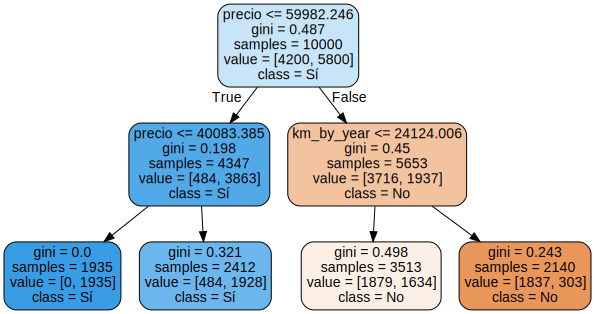

In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord, y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['No','Sí'], feature_names = features)

graph = graphviz.Source(dot_data)
graph

In [12]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 78.67
Intervalo [76.40, 80.94]


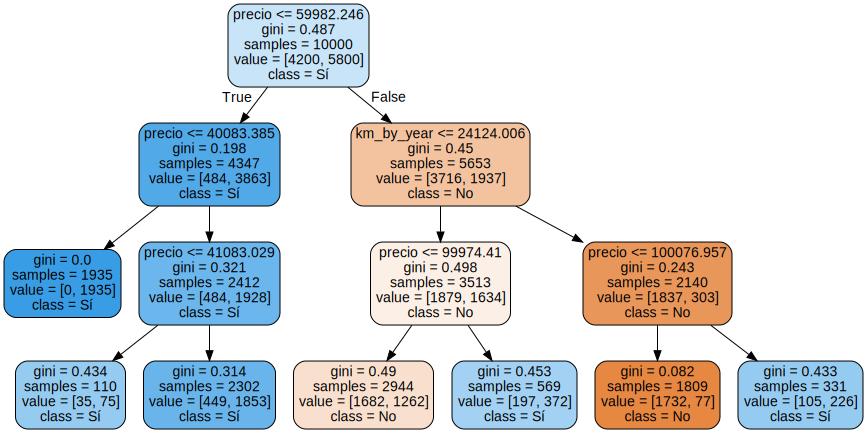

In [13]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord, y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['No','Sí'], feature_names = features)

graph = graphviz.Source(dot_data)
graph

In [14]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
# No por aumentar el valor de max_depth aumenta la precisión del modelo
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 77.19
Intervalo [75.26, 79.13]


## ¿Cuanto más complejo el árbol, mejor?


In [15]:
def iniciar_arbol_de_decision(max_depth):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
    test_score = results['test_score'].mean()*100
    print('Árbol max_depth = %d, testing = %.2f' % (max_depth, test_score))

for i in range(1,33):
    iniciar_arbol_de_decision(i)

Árbol max_depth = 1, testing = 75.78
Árbol max_depth = 2, testing = 75.78
Árbol max_depth = 3, testing = 78.67
Árbol max_depth = 4, testing = 78.63
Árbol max_depth = 5, testing = 78.56
Árbol max_depth = 6, testing = 78.12
Árbol max_depth = 7, testing = 77.96
Árbol max_depth = 8, testing = 77.86
Árbol max_depth = 9, testing = 77.38
Árbol max_depth = 10, testing = 77.19
Árbol max_depth = 11, testing = 76.97
Árbol max_depth = 12, testing = 76.49
Árbol max_depth = 13, testing = 75.81
Árbol max_depth = 14, testing = 75.66
Árbol max_depth = 15, testing = 75.16
Árbol max_depth = 16, testing = 75.11
Árbol max_depth = 17, testing = 74.74
Árbol max_depth = 18, testing = 74.33
Árbol max_depth = 19, testing = 74.34
Árbol max_depth = 20, testing = 74.22
Árbol max_depth = 21, testing = 73.80
Árbol max_depth = 22, testing = 73.81
Árbol max_depth = 23, testing = 73.38
Árbol max_depth = 24, testing = 73.43
Árbol max_depth = 25, testing = 73.14
Árbol max_depth = 26, testing = 73.04
Árbol max_depth = 27,

### Optimización de un hiper parámetro y el problema de overfit


In [18]:
def iniciar_arbol_de_decision(max_depth):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    print('Árbol max_depth = %d, training = %.2f, testing = %.2f' % (max_depth, train_score, test_score))
    tabla = [max_depth, train_score, test_score]
    return tabla

resultados = [iniciar_arbol_de_decision(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train', 'test'])
resultados.head()

Árbol max_depth = 1, training = 75.79, testing = 75.78
Árbol max_depth = 2, training = 75.79, testing = 75.78
Árbol max_depth = 3, training = 78.75, testing = 78.67
Árbol max_depth = 4, training = 78.79, testing = 78.63
Árbol max_depth = 5, training = 78.94, testing = 78.56
Árbol max_depth = 6, training = 79.17, testing = 78.12
Árbol max_depth = 7, training = 79.50, testing = 77.96
Árbol max_depth = 8, training = 79.89, testing = 77.86
Árbol max_depth = 9, training = 80.46, testing = 77.38
Árbol max_depth = 10, training = 81.16, testing = 77.19
Árbol max_depth = 11, training = 82.03, testing = 76.97
Árbol max_depth = 12, training = 82.89, testing = 76.49
Árbol max_depth = 13, training = 83.95, testing = 75.81
Árbol max_depth = 14, training = 85.03, testing = 75.66
Árbol max_depth = 15, training = 86.14, testing = 75.16
Árbol max_depth = 16, training = 87.19, testing = 75.11
Árbol max_depth = 17, training = 88.31, testing = 74.74
Árbol max_depth = 18, training = 89.26, testing = 74.33
Á

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


C:\Users\Julio\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Julio\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Julio\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Julio\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

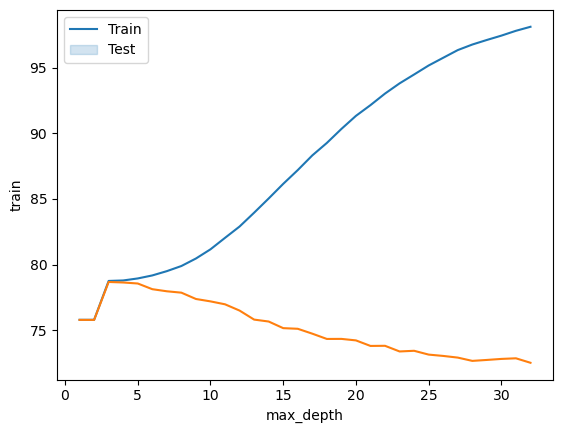

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x = 'max_depth', y = 'train', data = resultados);
sns.lineplot(x = 'max_depth', y = 'test', data = resultados);
plt.legend(['Train','Test']);

In [27]:
resultados.sort_values('test', ascending = False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
